# Creating our database: 

In [1]:
import winning_chances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)

In [2]:
mistake_bins = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]

#df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games_20.csv")

#table=winning_chances.compute_winning_chance_table(df)
#table=pd.read_csv("table_20.csv")
#table=pd.read_csv("winning_chances_all_moves.csv")
#summary_table=winning_chances.create_summary_table(df,mistake_bins=mistake_bins,winning_chance_table=table)


#summary_table=pd.read_csv("big_summary_table.csv")

summary_table=pd.read_csv("summary_table_20.csv")

# Random Forest Model

In [3]:
# Parameters and features that might be adjusted
Number_of_Openings = 70  # Number of top openings to consider
Color_Player = 'White'   # Player color to analyze ('White' or 'Black')
categorical_features = ['Opening', 'Result']  # Initial categorical features
numerical_features = ['AWCL']                 # Initial numerical features
total_moves_bins = [0, 40, 60, 80, 100, 120, np.inf]  # Bins for total moves

# Preprocess 'Opening' column to group less frequent openings as 'Other'
top_openings = summary_table['Opening'].value_counts().nlargest(Number_of_Openings).index.tolist()
summary_table['Opening'] = summary_table['Opening'].apply(lambda x: x if x in top_openings else 'Other')

# Filter the summary table for the specified player color
new_summary_table = summary_table[summary_table['Player'] == Color_Player].copy()

# Define mistake labels based on columns after 'AWCL'
start_index = new_summary_table.columns.get_loc('AWCL') + 1
mistake_labels = list(new_summary_table.columns[start_index:])

# Update numerical features to include mistake labels
numerical_features += mistake_labels

# Define total moves labels based on the bins
total_moves_labels = [
    f'({total_moves_bins[i]},{total_moves_bins[i+1]}]' if not np.isinf(total_moves_bins[i + 1]) else f'({total_moves_bins[i]},∞]'
    for i in range(len(total_moves_bins) - 1)
]

# Create 'TotalMovesInterval' using pd.cut
new_summary_table['TotalMovesInterval'] = pd.cut(
    new_summary_table['TotalMoves'],
    bins=total_moves_bins,
    labels=total_moves_labels,
    right=True,
    include_lowest=True
)

# Add 'TotalMovesInterval' to categorical features
categorical_features.append('TotalMovesInterval')

# Handle missing values in the target variable
new_summary_table = new_summary_table.dropna(subset=['Elo'])

# Process categorical features
for col in categorical_features:
    # Convert to 'category' dtype
    new_summary_table[col] = new_summary_table[col].astype('category')
    # Add 'Unknown' to categories if not present
    if 'Unknown' not in new_summary_table[col].cat.categories:
        new_summary_table[col] = new_summary_table[col].cat.add_categories(['Unknown'])
    # Fill NaN values with 'Unknown'
    new_summary_table[col] = new_summary_table[col].fillna('Unknown')

# Handle missing values in numerical features (mistake intervals)
new_summary_table[numerical_features] = new_summary_table[numerical_features].fillna(0)

# Define target variable
y = new_summary_table['Elo']

# Define features
X = new_summary_table[categorical_features + numerical_features]

# Split the data with stratification on binned 'Elo' values
y_binned = pd.qcut(y, q=10, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=40,
    stratify=y_binned
)

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features unchanged
)

# Create a pipeline with Random Forest Regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,       # Number of trees in the forest
        random_state=42,        # For reproducibility
        n_jobs=-1               # Use all available CPU cores
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Calculate percentage of predictions within a threshold
absolute_errors = np.abs(y_pred - y_test)
threshold = 300
within_threshold = np.sum(absolute_errors <= threshold)
total_predictions = len(y_test)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"Percentage of predictions within ±{threshold} Elo: {percentage_within_threshold:.2f}%")

# Feature Importances
# Get feature names after preprocessing
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([onehot_feature_names, numerical_features])

# Get feature importances from the Random Forest model
importances = pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the top 10 important features
print("\nTop 10 Important Features:")
print(feature_importances.head(10))
print(f"min: {y_pred.min()}")
print(f"max: {y_pred.max()}")
print(f"mean: {y_pred.mean()}")



Root Mean Squared Error (RMSE): 265.52
R-squared Score (R²): 0.10
Percentage of predictions within ±300 Elo: 76.24%

Top 10 Important Features:
                       Feature  Importance
80                        AWCL    0.354382
81                      (5,10]    0.088506
82                     (10,15]    0.060061
83                     (15,20]    0.041587
84                     (20,25]    0.031495
71                  Result_0-1    0.024995
85                     (25,30]    0.022401
86                     (30,35]    0.018076
78  TotalMovesInterval_(60,80]    0.016807
88                     (40,50]    0.016110
min: 1574.02
max: 2636.4
mean: 2218.5636280679673


# Graphs and observations

C:\Users\foivo\AppData\Local\Temp\ipykernel_30936\3899923986.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_mistake_per_elo_bin = new_summary_table.groupby('EloBin')['WeightedMistakeScore'].mean().reset_index()


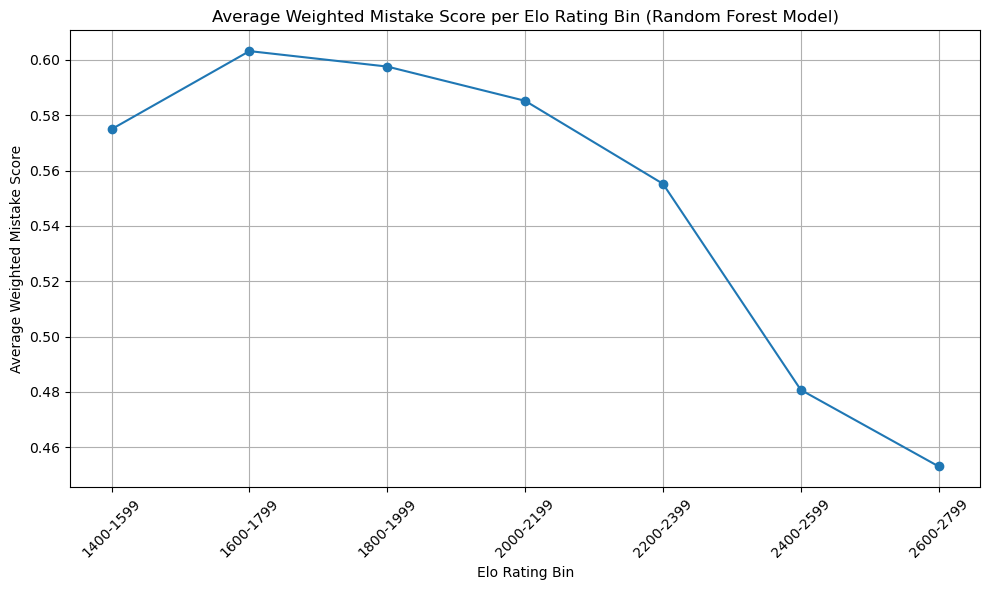

In [4]:
# Assuming the Random Forest model is trained and feature importances are computed
import matplotlib.pyplot as plt
import pandas as pd

# Get the feature names after preprocessing
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([onehot_feature_names, numerical_features])

# Get feature importances from the Random Forest model
importances = pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Get the feature importances for mistake labels
mistake_feature_importances = feature_importances[feature_importances['Feature'].isin(mistake_labels)]

# Create a dictionary of mistake importances
mistake_importances = mistake_feature_importances.set_index('Feature')['Importance'].to_dict()

# Compute 'WeightedMistakeScore' using the importances
coefficients_series = pd.Series(mistake_importances)
# Fill missing coefficients with zero to match mistake_labels
coefficients_series = coefficients_series.reindex(mistake_labels, fill_value=0)
new_summary_table['WeightedMistakeScore'] = new_summary_table[mistake_labels].dot(coefficients_series)

# Proceed with creating Elo bins and plotting as before

# Step 3: Create Elo bins and labels
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]
elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1] - 1  # Subtract 1 to make the upper limit inclusive
    label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)

# Assign Elo bins to the data
new_summary_table['EloBin'] = pd.cut(
    new_summary_table['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False,        # Left-inclusive intervals
    include_lowest=True # Include the lowest value
)

# Remove rows with missing 'EloBin' values (if any)
new_summary_table = new_summary_table.dropna(subset=['EloBin'])

# Step 4: Compute average 'WeightedMistakeScore' per Elo bin
avg_mistake_per_elo_bin = new_summary_table.groupby('EloBin')['WeightedMistakeScore'].mean().reset_index()

# Step 5: Plot the line graph connecting the averages
plt.figure(figsize=(10, 6))
plt.plot(avg_mistake_per_elo_bin['EloBin'], avg_mistake_per_elo_bin['WeightedMistakeScore'], marker='o')
plt.title('Average Weighted Mistake Score per Elo Rating Bin (Random Forest Model)')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Weighted Mistake Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Assume all necessary libraries are already imported and previous code has been executed
# The pipeline 'pipeline' has been trained, and 'categorical_features', 'numerical_features',
# and 'top_openings' are defined from your previous code.

# Step 1: Select 20 games with Elo < 1500
# Use the original 'new_summary_table' and filter for the specified player color if needed
new_summary_table_low_elo = new_summary_table[new_summary_table['Elo'] >2500].copy()

# Check if there are at least 20 games; if not, adjust accordingly
if len(new_summary_table_low_elo) < 20:
    print(f"Only {len(new_summary_table_low_elo)} games found with Elo < 1500.")
    sample_games = new_summary_table_low_elo
else:
    # Randomly select 20 games
    sample_games = new_summary_table_low_elo.sample(n=20, random_state=42)

# Step 2: Preprocess the selected games

# Ensure the 'Opening' column is processed the same way as in training
# If 'top_openings' was used to group less frequent openings under 'Other', apply the same here
sample_games['Opening'] = sample_games['Opening'].apply(lambda x: x if x in top_openings else 'Other')

# Process categorical features
for col in categorical_features:
    sample_games[col] = sample_games[col].astype('category')
    # Ensure the categories match those in the training set
    sample_games[col] = sample_games[col].cat.set_categories(new_summary_table[col].cat.categories)
    # Fill NaN values with 'Unknown'
    sample_games[col] = sample_games[col].fillna('Unknown')

# Handle missing values in numerical features
sample_games[numerical_features] = sample_games[numerical_features].fillna(0)

# Define features for prediction
X_new = sample_games[categorical_features + numerical_features]

# Step 3: Predict using the trained model
y_new_pred = pipeline.predict(X_new)

# Step 4: Output the predictions per game
sample_games = sample_games.reset_index(drop=True)  # Reset index for clarity
sample_games['Predicted_Elo'] = y_new_pred

# Display the predictions per game
print("Predictions for each game:")
print(sample_games[['GameID', 'Elo', 'Predicted_Elo']])

# Step 5: Compute and display average, min, and max of the predictions
average_pred = y_new_pred.mean()
min_pred = y_new_pred.min()
max_pred = y_new_pred.max()

print(f"\nAverage Predicted Elo: {average_pred:.2f}")
print(f"Minimum Predicted Elo: {min_pred:.2f}")
print(f"Maximum Predicted Elo: {max_pred:.2f}")


Predictions for each game:
     GameID     Elo  Predicted_Elo
0    2715.0  2612.0        2344.09
1   35588.0  2562.0        2503.13
2   10485.0  2592.0        2436.43
3   24289.0  2509.0        2341.92
4   22600.0  2506.0        2419.18
5    7725.0  2636.0        2325.48
6   17142.0  2584.0        2507.48
7    6364.0  2516.0        2332.09
8   25367.0  2538.0        2460.13
9   29501.0  2592.0        2451.51
10  17314.0  2529.0        2495.00
11  26756.0  2644.0        2548.21
12  24977.0  2588.0        2440.05
13   9097.0  2788.0        2648.93
14  12688.0  2612.0        2399.54
15   9533.0  2592.0        2434.83
16  29609.0  2615.0        2323.32
17  31538.0  2593.0        2542.38
18  11508.0  2607.0        2482.42
19  31699.0  2552.0        2320.62

Average Predicted Elo: 2437.84
Minimum Predicted Elo: 2320.62
Maximum Predicted Elo: 2648.93


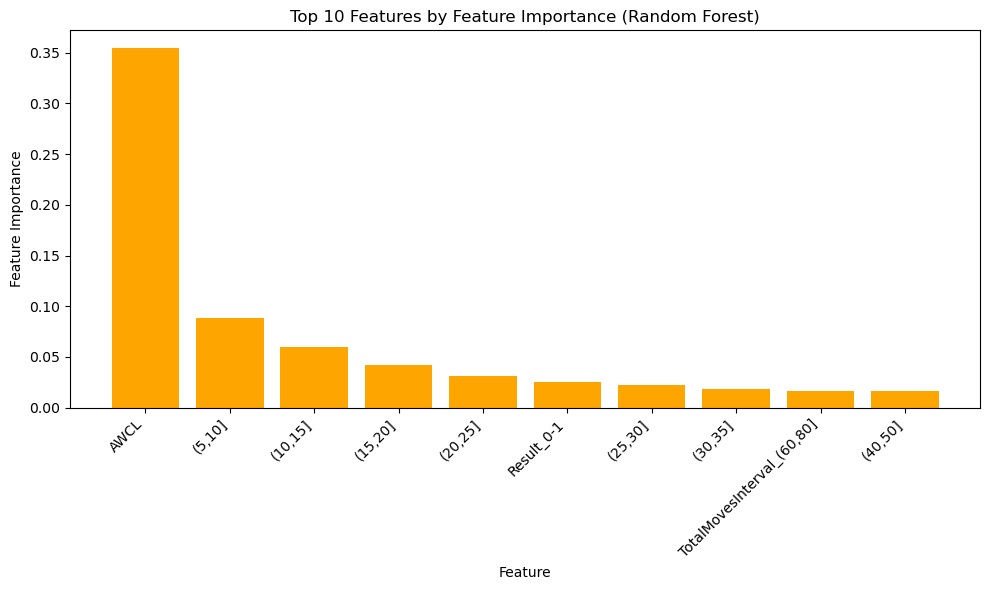

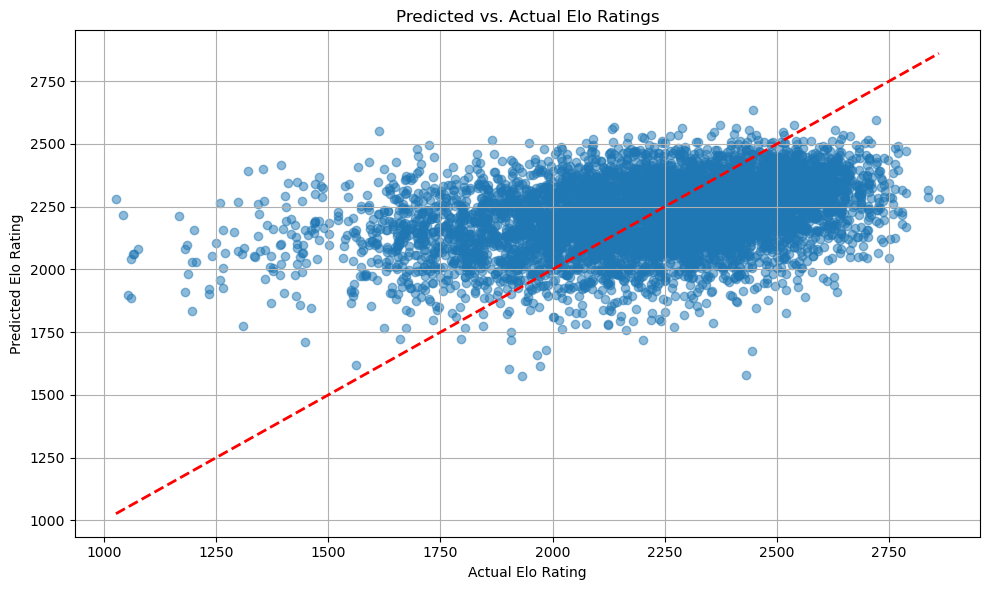

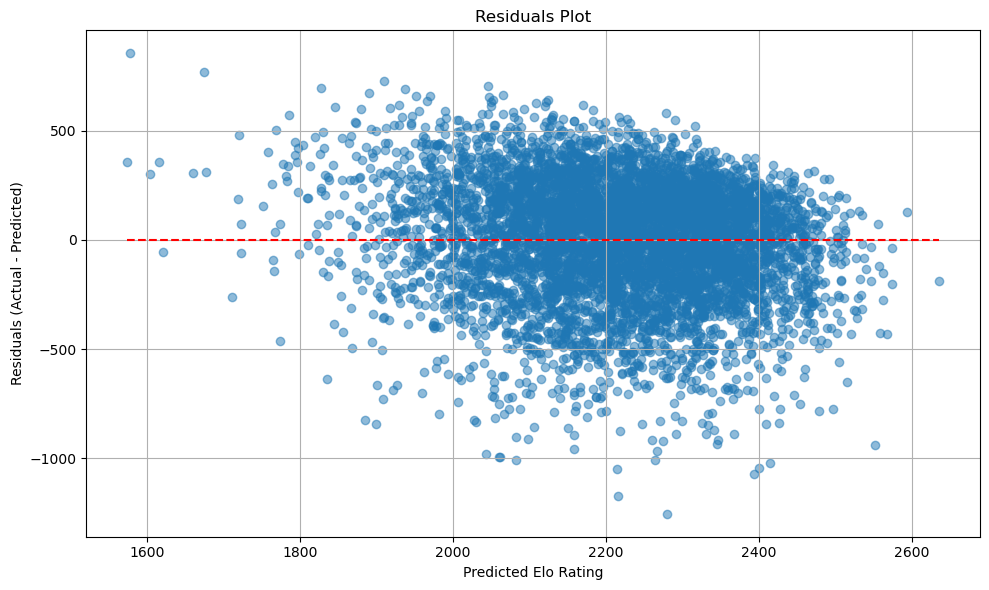

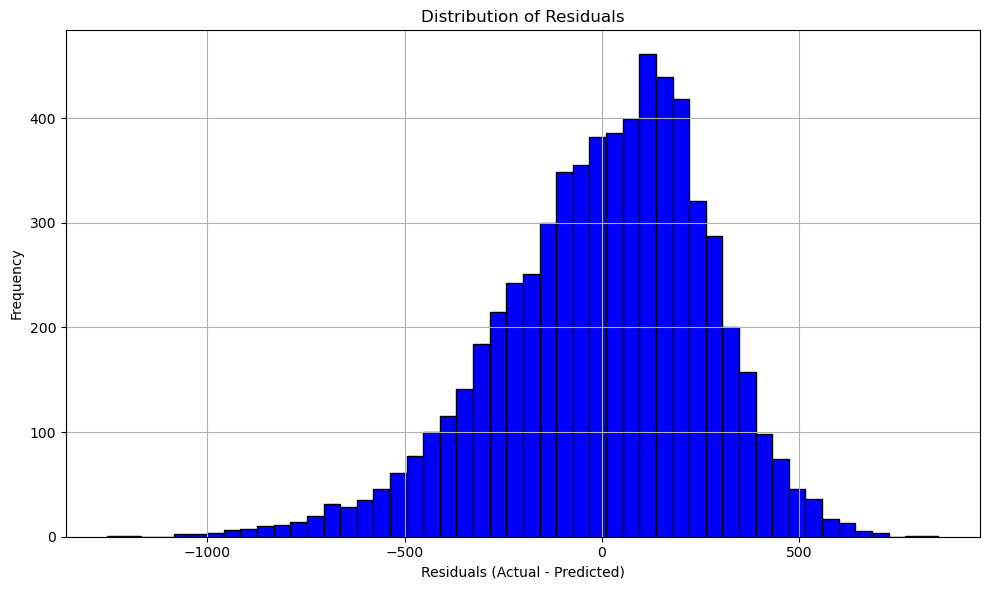

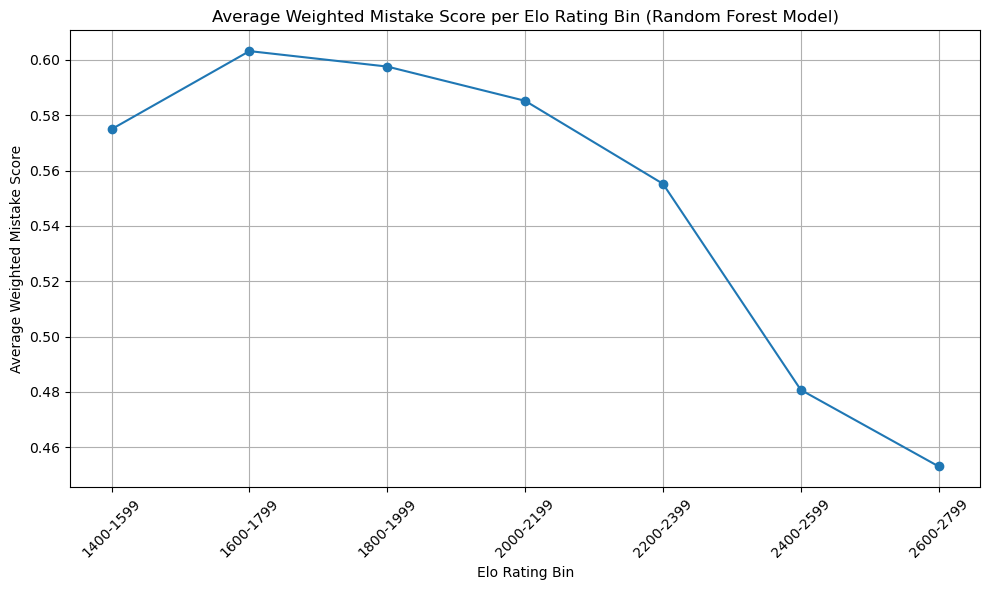

In [15]:
# 1. Feature Importance Bar Plot (Top 10 Features)
# Get feature names after preprocessing
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([onehot_feature_names, numerical_features])

# Get feature importances from the Random Forest model
importances = pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the feature importances in descending order
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Get the top 10 features by importance
top_features = feature_importances_sorted.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Importance'], color='orange')
plt.title('Top 10 Features by Feature Importance (Random Forest)')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Predicted vs. Actual Elo Ratings Scatter Plot
# Assuming y_test and y_pred are defined
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('Predicted vs. Actual Elo Ratings')
plt.xlabel('Actual Elo Rating')
plt.ylabel('Predicted Elo Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Residuals Plot
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed', colors='red')
plt.title('Residuals Plot')
plt.xlabel('Predicted Elo Rating')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Error Distribution Histogram
# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Average Weighted Mistake Score per Elo Rating Bin Plot
# Assuming 'new_summary_table' and 'avg_mistake_per_elo_bin' are defined
plt.figure(figsize=(10, 6))
plt.plot(avg_mistake_per_elo_bin['EloBin'], avg_mistake_per_elo_bin['WeightedMistakeScore'], marker='o')
plt.title('Average Weighted Mistake Score per Elo Rating Bin (Random Forest Model)')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Weighted Mistake Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
